In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [2]:
def clean_cancelations(csv_data):
    
    #drops columns that are empty & 'whose meanings do not matter'
    
#     if(all(x in csv_data.columns for x in ['survey_question_4', 'ruid', 'callback'])):
#         csv_data.drop(columns=['survey_question_4','ruid','callback'],inplace=True)
    if(all(x in csv_data.columns for x in ['survey_question_4', 'ruid'])):
        csv_data.drop(columns=['survey_question_4', 'ruid'],inplace=True)
    
    #replaces NaN with 'blank'
    csv_data['survey_question_1'].replace({np.nan: -1}, inplace=True)
    csv_data['survey_question_2'].replace({np.nan: -1}, inplace=True)
    csv_data['survey_question_3'].replace({np.nan: -1}, inplace=True)
    csv_data['survey_followup'].replace({np.nan: 0, 'n': 1, 'y':2}, inplace=True)
    
    if(all(x not in csv_data.columns for x in ['first_timestamp', 'first_callback','has_canceled'])):
        
        #creates new column that give first recorded timestamp per userid
        csv_data['first_timestamp'] = csv_data.groupby('userid').event_timestamp.transform('min')
        
        #checks to make sure first timestamp is LEQ all other timestamps for the userid
        error_list = csv_data[csv_data['event_timestamp'] < csv_data['first_timestamp']]
        if len(error_list) > 0:
            print('Failed to output minimum timestamps.')
            print(error_list)
            return
           
        #creates new column that notes if this customer has ever canceled: 0 for no, 1 for yes
        csv_data['has_canceled'] = csv_data.groupby('userid').event_label.transform('max')
        csv_data['has_canceled'].replace({'activation': 0, 'cancellation': 1}, inplace=True)
        
    if(all(x in csv_data.columns for x in ['event_timestamp', 'event_label'])):
        csv_data.drop(csv_data[csv_data['event_timestamp'] > csv_data['first_timestamp']].index, inplace = True)
        csv_data.drop(columns=['event_timestamp', 'event_label'],inplace=True)
        csv_data.drop_duplicates(inplace=True)
        csv_data.reset_index(drop=True,inplace=True)
    

    
    return csv_data

In [3]:
csv_data = pd.read_csv('Data_Science.csv')

df = clean_cancelations(csv_data)

#df

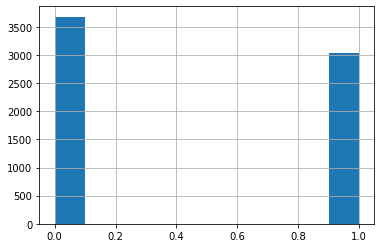

In [4]:
df.has_canceled.hist()

In [5]:
X = df.drop(columns=['has_canceled'])
y = df.has_canceled

dummy_list = ['survey_question_1','survey_question_2','survey_question_3','survey_followup','callback']
df_dummies = pd.get_dummies(df, prefix=dummy_list, columns=dummy_list)
X = pd.get_dummies(X, prefix=dummy_list, columns=dummy_list)

In [6]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

X_fs = X
y_fs = y

model = LogisticRegression()
rfe = RFE(model, 35)
fit = rfe.fit(X_fs, y_fs)
#print("Num Features: %s" % (fit.n_features_))
#print("Selected Features: %s" % (fit.support_))
#print("Feature Ranking: %s" % (fit.ranking_))

In [7]:
fs_results = zip(list(fit.support_),list(X_fs.columns))

selected_feats = []
for TF, col_name in fs_results:
    if TF == True:
        selected_feats.append(col_name)
#print(selected_feats)

In [8]:
num_feats = 31
highest_corr_feats = list(df_dummies.corr().has_canceled.abs().sort_values(ascending=False).index[1:num_feats+1])

In [9]:
df.corr()

,userid,survey_question_1,survey_question_2,survey_question_3,survey_followup,callback,first_timestamp,has_canceled
userid,1.000000,0.010751,0.007533,-0.055290,-0.000327,-0.011456,0.852975,-0.042278
survey_question_1,0.010751,1.000000,-0.310425,0.609231,-0.429629,-0.011946,0.012902,-0.020881
survey_question_2,0.007533,-0.310425,1.000000,-0.253987,0.702068,0.009322,0.011536,0.023401
survey_question_3,-0.055290,0.609231,-0.253987,1.000000,-0.364536,-0.005047,-0.045680,-0.025573
survey_followup,-0.000327,-0.429629,0.702068,-0.364536,1.000000,0.018604,0.004976,0.034139
callback,-0.011456,-0.011946,0.009322,-0.005047,0.018604,1.000000,-0.007047,0.006843
first_timestamp,0.852975,0.012902,0.011536,-0.045680,0.004976,-0.007047,1.000000,-0.042413
has_canceled,-0.042278,-0.020881,0.023401,-0.025573,0.034139,0.006843,-0.042413,1.000000


In [10]:
df_dummies.corr()

,userid,first_timestamp,has_canceled,survey_question_1_-1.0,survey_question_1_1.0,survey_question_1_2.0,survey_question_1_3.0,survey_question_1_4.0,survey_question_1_5.0,survey_question_1_6.0,...,callback_0.0,callback_1.0,callback_2.0,callback_3.0,callback_4.0,callback_5.0,callback_6.0,callback_7.0,callback_8.0,callback_9.0
userid,1.000000,0.852975,-0.042278,-0.005237,-0.020453,0.001616,-0.021726,-0.001247,0.006616,0.023615,...,0.000196,-0.000060,0.008056,-0.018815,0.028792,0.018590,-0.008411,-0.010532,-0.003950,-0.013484
first_timestamp,0.852975,1.000000,-0.042413,-0.004512,-0.017593,0.002542,-0.021814,-0.002645,-0.002185,0.019537,...,-0.000327,-0.004010,0.001618,-0.012857,0.029088,0.016211,-0.011110,-0.003666,0.001259,-0.015800
has_canceled,-0.042278,-0.042413,1.000000,-0.014043,0.044801,0.008047,0.011479,0.002452,-0.001468,0.011005,...,-0.006381,-0.007331,0.013905,0.000869,0.001654,-0.009017,-0.004800,-0.005535,-0.000605,0.016813
survey_question_1_-1.0,-0.005237,-0.004512,-0.014043,1.000000,-0.019333,-0.011210,-0.013953,-0.013753,-0.019767,-0.017011,...,-0.004063,-0.018020,0.013858,-0.007053,-0.003483,-0.018351,0.026499,-0.004549,0.014923,0.000007
survey_question_1_1.0,-0.020453,-0.017593,0.044801,-0.019333,1.000000,-0.011903,-0.014816,-0.014604,-0.020990,-0.018064,...,0.004942,-0.004413,0.004205,-0.012193,-0.008576,-0.015488,-0.012187,0.016169,0.001704,0.026542
survey_question_1_2.0,0.001616,0.002542,0.008047,-0.011210,-0.011903,1.000000,-0.008591,-0.008467,-0.012170,-0.010474,...,-0.003802,0.021194,-0.004186,-0.017247,0.008621,-0.015432,0.008574,-0.014194,0.002369,0.014453
survey_question_1_3.0,-0.021726,-0.021814,0.011479,-0.013953,-0.014816,-0.008591,1.000000,-0.010540,-0.015149,-0.013037,...,-0.005574,0.009984,0.003569,-0.007791,-0.000276,0.004756,-0.005192,-0.018103,0.014024,0.004375
survey_question_1_4.0,-0.001247,-0.002645,0.002452,-0.013753,-0.014604,-0.008467,-0.010540,1.000000,-0.014931,-0.012850,...,0.000244,-0.003801,-0.010012,0.002648,0.010576,0.015697,-0.014151,0.002917,-0.004474,0.000497
survey_question_1_5.0,0.006616,-0.002185,-0.001468,-0.019767,-0.020990,-0.012170,-0.015149,-0.014931,1.000000,-0.018469,...,-0.007605,0.000612,0.002013,0.009339,0.024261,-0.006788,-0.010532,-0.004045,-0.007334,-0.000339
survey_question_1_6.0,0.023615,0.019537,0.011005,-0.017011,-0.018064,-0.010474,-0.013037,-0.012850,-0.018469,1.000000,...,0.001689,0.010922,-0.006869,0.018084,0.006277,-0.013628,0.002200,-0.019744,0.001944,-0.001995


In [11]:
# from sklearn import preprocessing

# scaler = preprocessing.StandardScaler().fit(X)

# X_scaled=scaler.transform(X)
# y = y.ravel()

In [12]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X[highest_corr_feats], y.ravel(), test_size=0.25, random_state = 42)

In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

logreg = LogisticRegression(class_weight = 'balanced')
logreg.fit(X_train, y_train)

LogisticRegression(class_weight='balanced')

In [14]:
y_pred_lr = logreg.predict(X_test)

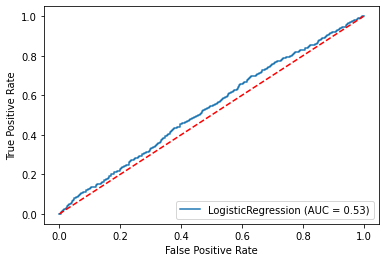

In [15]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import plot_roc_curve
plot_roc_curve(logreg, X_test, y_test)
plt.plot([0, 1], [0, 1],'r--')
plt.show()

In [16]:
logreg.predict_proba(X_test)

array([[0.51837499, 0.48162501],
       [0.47143124, 0.52856876],
       [0.51825105, 0.48174895],
       ...,
       [0.51843566, 0.48156434],
       [0.52061755, 0.47938245],
       [0.48050975, 0.51949025]])

In [17]:
probs = pd.DataFrame(logreg.predict_proba(X_test))

In [18]:
probs['label'] = y_test
probs['pred'] = y_pred_lr

In [19]:
probs.columns = probs.columns.map(str)
probs.rename(columns={'0': "neg", '1': "pos"},inplace=True)

In [20]:
probs.sort_values(by=['pos'], axis=0, ascending=False, inplace=True,ignore_index=True)

In [21]:
probs

,neg,pos,label,pred
0,0.452731,0.547269,0,1
1,0.452741,0.547259,0,1
2,0.452764,0.547236,0,1
3,0.453037,0.546963,1,1
4,0.453479,0.546521,0,1
...,...,...,...,...
1673,0.521357,0.478643,1,0
1674,0.521498,0.478502,0,0
1675,0.521507,0.478493,0,0
1676,0.521507,0.478493,0,0


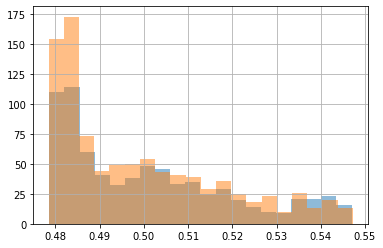

In [22]:
probs.loc[probs['label'] == 1].pos.hist(alpha=0.5,bins=20)
probs.loc[probs['label'] == 0].pos.hist(alpha=0.5,bins=20)

In [23]:
correct = pd.crosstab(probs.label,probs.pred)[0].loc[0] + pd.crosstab(probs.label,probs.pred)[1].loc[1]
total = pd.crosstab(probs.label,probs.pred).sum().sum()
accuracy = round(correct / total,4)
accuracy


0.5352

In [24]:
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc, make_scorer, recall_score, accuracy_score, precision_score, confusion_matrix
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(random_state = 17)

param_grid = {
    'n_estimators' : [60,72,80],
    'max_depth': [8,10,12]
}

scorers = {
    'precision_score': make_scorer(precision_score),
    'recall_score': make_scorer(recall_score),
    'accuracy_score': make_scorer(accuracy_score),
    'roc_auc_score': make_scorer(roc_auc_score)
}

In [25]:
def grid_search_wrapper(refit_score='accuracy_score'):
    """
    fits a GridSearchCV classifier using refit_score for optimization
    prints classifier performance metrics
    """
    grid_search = GridSearchCV(clf, param_grid, scoring=scorers, refit=refit_score,
                           cv=3, return_train_score=True, n_jobs=-1)
    grid_search.fit(X_train, y_train)

    # make the predictions
    y_pred2 = grid_search.predict(X_test.values)

    print('Best params for {}'.format(refit_score))
    print(grid_search.best_params_)

    # confusion matrix on the test data.
    print('\nConfusion matrix of Random Forest optimized for {} on the test data:'.format(refit_score))
    conf_mat = pd.DataFrame(confusion_matrix(y_test, y_pred2),columns=['pred_neg', 'pred_pos'], index=['neg', 'pos'])
    print(conf_mat)
    print('\nSensitivity: ', round(conf_mat.pred_pos[1]/(conf_mat.pred_neg[1]+conf_mat.pred_pos[1]),4))
    print('\nSpecificity: ', round(conf_mat.pred_neg[0]/(conf_mat.pred_neg[0]+conf_mat.pred_pos[0]),4))
    
    print('\nAccuracy: ', round((conf_mat.pred_pos.loc['pos'] + conf_mat.pred_neg.loc['neg']) / conf_mat.sum().sum(),4))
    return grid_search, y_pred2

In [26]:
grid_search_clf,y_pred2 = grid_search_wrapper(refit_score='accuracy_score')

Best params for accuracy_score
{'max_depth': 8, 'n_estimators': 72}

Confusion matrix of Random Forest optimized for accuracy_score on the test data:
     pred_neg  pred_pos
neg       849        84
pos       634       111

Sensitivity:  0.149

Specificity:  0.91

Accuracy:  0.5721


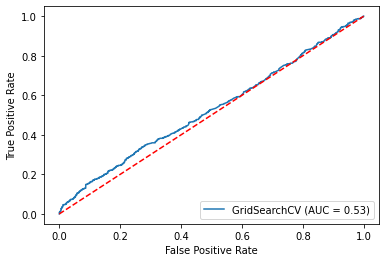

In [27]:
from sklearn.metrics import plot_roc_curve
plot_roc_curve(grid_search_clf, X_test, y_test)
plt.plot([0, 1], [0, 1],'r--')
plt.show()

In [28]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

In [29]:
xgboost = XGBClassifier(random_state = 17)
params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5]
        }
xgboost.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=17,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [30]:
y_pred3 = xgboost.predict(X_test)
predictions = [round(value) for value in y_pred3]

In [31]:
conf_mat_xgb = pd.DataFrame(confusion_matrix(y_test, y_pred3),columns=['pred_neg', 'pred_pos'], index=['neg', 'pos'])
print('\nConfusion matrix of the XGBoost model\n')
print(conf_mat_xgb)
print('\nSensitivity: ', round(conf_mat_xgb.pred_pos[1]/(conf_mat_xgb.pred_neg[1]+conf_mat_xgb.pred_pos[1]),4))
print('Specificity: ', round(conf_mat_xgb.pred_neg[0]/(conf_mat_xgb.pred_neg[0]+conf_mat_xgb.pred_pos[0]),4))

print('\nAccuracy: ', round((conf_mat_xgb.pred_pos.loc['pos'] + conf_mat_xgb.pred_neg.loc['neg']) / conf_mat_xgb.sum().sum(),4))


Confusion matrix of the XGBoost model

     pred_neg  pred_pos
neg       640       293
pos       470       275

Sensitivity:  0.3691
Specificity:  0.686

Accuracy:  0.5453


In [32]:
from keras.models import Sequential
from keras.layers import Dense

# define the keras model
nn_model = Sequential()
nn_model.add(Dense(50, input_dim=41, activation='relu'))
nn_model.add(Dense(16, activation='relu'))
nn_model.add(Dense(4, activation='relu'))
nn_model.add(Dense(1, activation='sigmoid'))
# compile the keras model
nn_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# fit the keras model on the dataset
nn_model.fit(X, y, epochs=10, batch_size=10)
# evaluate the keras model
_, accuracy = nn_model.evaluate(X, y)
print('Accuracy: %.2f' % (accuracy*100))

Epoch 1/10
672/672 [==============================] - 1s 1ms/step - loss: 2132804.5000 - accuracy: 0.5056
Epoch 2/10
672/672 [==============================] - 1s 1ms/step - loss: 1649117.5000 - accuracy: 0.5042
Epoch 3/10
672/672 [==============================] - 1s 1ms/step - loss: 1171070.6250 - accuracy: 0.4956
Epoch 4/10
672/672 [==============================] - 1s 1ms/step - loss: 1178845.1250 - accuracy: 0.5044
Epoch 5/10
672/672 [==============================] - 1s 1ms/step - loss: 1193903.7500 - accuracy: 0.4961
Epoch 6/10
672/672 [==============================] - 1s 1ms/step - loss: 1082337.8750 - accuracy: 0.5071
Epoch 7/10
672/672 [==============================] - 1s 1ms/step - loss: 942265.8750 - accuracy: 0.5025
Epoch 8/10
672/672 [==============================] - 1s 1ms/step - loss: 988549.0000 - accuracy: 0.5013
Epoch 9/10
672/672 [==============================] - 1s 1ms/step - loss: 817885.1250 - accuracy: 0.5016
Epoch 10/10
210/210 [============================